In [2]:
import pandas as pd
import os
import dotenv

dotenv.load_dotenv()
DATA_DIR = os.getenv("DATA_DIR", "./data")
SOUP_DIR = os.getenv("SOUP_DIR", ".models/soup_models")
ANALYSIS_DIR = os.getenv("ANALYSIS_DIR", "./analysis")

In [33]:
df_soups = pd.read_parquet(os.path.join(ANALYSIS_DIR, "rand_soups_seed_42.parquet"), engine="fastparquet")
df_permutations = pd.read_parquet(os.path.join(ANALYSIS_DIR, "permutation_ablation_results.parquet"), engine="fastparquet")
df_similarities = pd.read_parquet(os.path.join(ANALYSIS_DIR, "similarity_metrics.parquet"), engine="fastparquet")

In [36]:
# Combine into unified table by keys
n_soups = df_soups.shape[0]
n_permutations = df_permutations.shape[0]
n_similarities = df_similarities.shape[0]

print(f"Number of soups: {n_soups}")
print(f"Number of permutations: {n_permutations}")
print(f"Number of similarity metrics: {n_similarities}")

def normalize_keys(df):
    df[["key_a", "key_b"]] = (
        df[["key_a", "key_b"]]
        .astype(str)
        .apply(lambda row: pd.Series(sorted(row)), axis=1)
    )
    return df

for df in [df_soups, df_permutations, df_similarities]:
    df = normalize_keys(df)
    df.sort_values(by=["key_a", "key_b"]).reset_index(drop=True)

df_all = (
    df_soups
    .merge(df_permutations, on=["key_a", "key_b"], how="outer")
    .merge(df_similarities, on=["key_a", "key_b"], how="outer")
)

df_all

# Save to disk
df_all.to_parquet(os.path.join(ANALYSIS_DIR, "combined_analysis.parquet"), engine="fastparquet", index=False)

Number of soups: 5460
Number of permutations: 5460
Number of similarity metrics: 5356


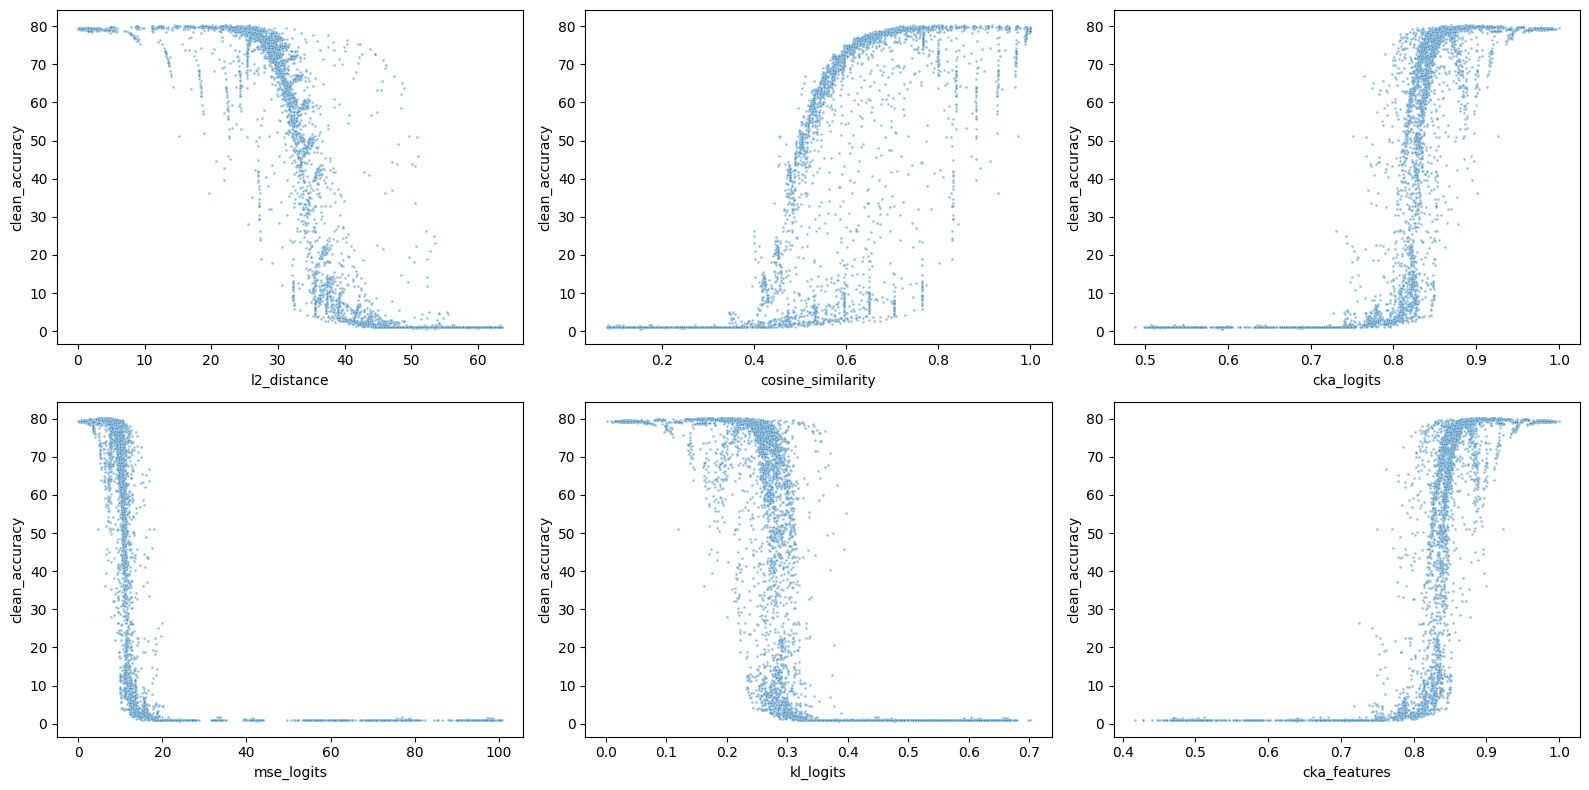

In [63]:
df_combined = pd.read_parquet(os.path.join(ANALYSIS_DIR, "combined_analysis.parquet"), engine="fastparquet")

# Plot distribution of clean_accuracy
import matplotlib.pyplot as plt
import seaborn as sns

# plt.hist(df_combined["clean_accuracy"], bins=20)
# plt.xlabel("Clean Accuracy")
# plt.ylabel("Frequency")
# plt.title("Distribution of Clean Accuracy")
# plt.show()

# plot clean accuracy vs metrics
metrics = [
    "l2_distance",
    "cosine_similarity",
    "cka_logits",
    "mse_logits",
    "kl_logits",
    "cka_features",
]

#4x2 grid of scatter plots with seaborn
fig, axes = plt.subplots(2, 3, figsize=(16,8))
for i, metric in enumerate(metrics):
    ax = axes[i // 3, i % 3]
    sns.scatterplot(data=df_combined, x=metric, y="clean_accuracy", ax=ax, alpha=0.5, marker='.', s=15.0)
plt.tight_layout()
plt.show()

In [7]:
# find result for key_a = 50_4 and key_b = 50_4
key_a = "100_4"
key_b = "120_3"

if key_a > key_b:
    key_a, key_b = key_b, key_a

result = df_soups[(df_soups["key_a"] == key_a)]
result = result[result["key_b"] == key_b]
result

,key_a,key_b,branch_epoch_a,branch_epoch_b,model_id_a,model_id_b,clean_accuracy,clean_loss,acc_corr_3,loss_corr_3
3254,100_4,120_3,100,120,4,3,68.31,1.566512,35.62,3.081643
